In [19]:
import pandas as pd
import preprocessing as pre
from domain import Framework

df = pd.read_csv("../isolde-experiments/data/80b8403f476d5b.csv")
df = pre.preprocess(df, txn_num=(4, 10))
df['timeout'] = df['outcome'].apply(lambda o: o == 'TIMEOUT')

# remove rows that have not RA_c in them
def has_RA_c(row):
    problem = row['problem']
    return problem.neg.name == "RA" and problem.neg.framework == Framework.CERONE

df = df.loc[df.apply(lambda row: not has_RA_c(row), axis=1)]
df

,implementation,solver,problem,num_txn,num_keys,num_values,num_sessions,candidates,initial_clauses,final_clauses,avg_time_ms,min_time_ms,max_time_ms,outcome,expected,frameworks,problem_type,timeout
0,all,glucose,CC_b|CC_c,4,5,5,3,36,10738,17330,302,299,304,UNSAT,UNSAT,"(b, c)","(UNSAT, 2)",False
1,all,glucose,CC_b|CC_c,5,5,5,3,483,17255,88805,6788,6769,6798,UNSAT,UNSAT,"(b, c)","(UNSAT, 2)",False
2,all,glucose,CC_b|CC_c,6,5,5,3,-1,-1,-1,3600000,3600000,3600000,TIMEOUT,UNSAT,"(b, c)","(UNSAT, 2)",True
3,all,glucose,CC_b|PC_b,4,5,5,3,2,9903,11587,17,16,18,SAT,SAT,"(b,)","(SAT, 1)",False
4,all,glucose,CC_b|PC_b,5,5,5,3,2,14849,17885,26,25,27,SAT,SAT,"(b,)","(SAT, 1)",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,no_smart_search,glucose,TapRA_b|RA_b,6,5,5,3,1,66645,66645,34,34,34,SAT,SAT,"(b,)","(SAT, 1)",False
1378,no_smart_search,glucose,TapRA_b|RA_b,7,5,5,3,1,101661,101661,54,53,57,SAT,SAT,"(b,)","(SAT, 1)",False
1379,no_smart_search,glucose,TapRA_b|RA_b,8,5,5,3,1,149743,149743,73,73,73,SAT,SAT,"(b,)","(SAT, 1)",False
1380,no_smart_search,glucose,TapRA_b|RA_b,9,5,5,3,1,208978,208978,221,219,223,SAT,SAT,"(b,)","(SAT, 1)",False


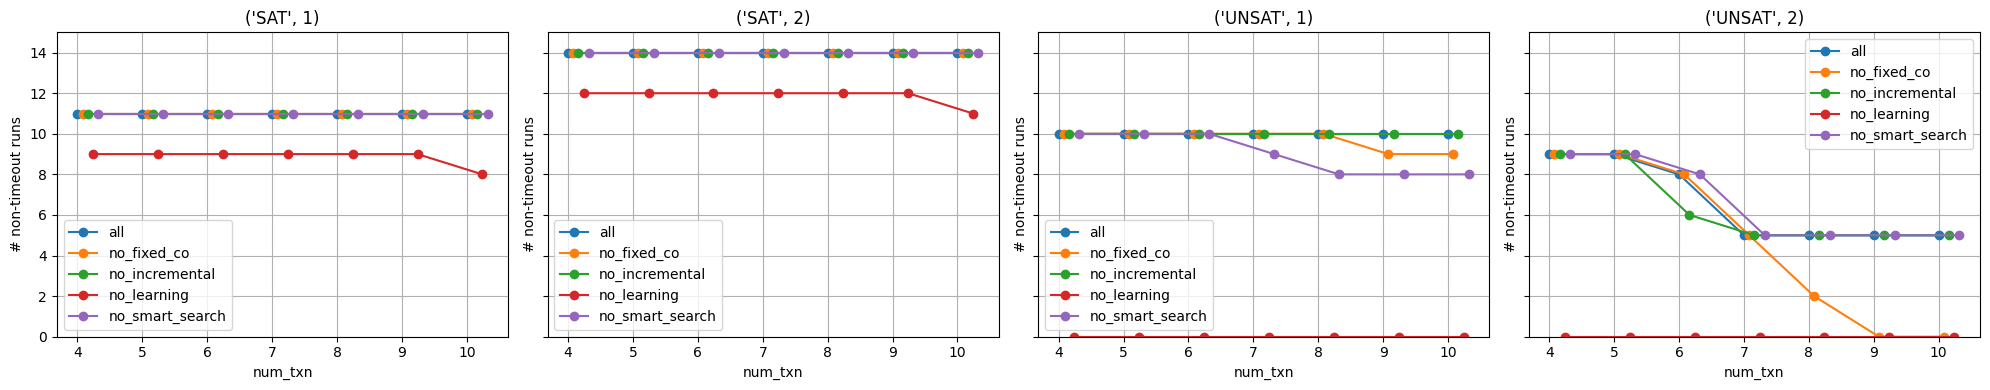

In [20]:
import matplotlib.pyplot as plt

# Group and count non-timeout rows
#filtered = df[df['implementation'].isin(['all', 'no_learning'])]
filtered = df[df['timeout'] == False]

# Build the full combination grid
full_index = pd.MultiIndex.from_product(
    [df['problem_type'].unique(), df['num_txn'].unique(), df['implementation'].unique()],
    names=['problem_type', 'num_txn', 'implementation']
)

# Reindex and fill missing with 0
grouped = (
    filtered
    .groupby(['problem_type', 'num_txn', 'implementation'])
    .size()
    .reindex(full_index, fill_value=0)
    .reset_index(name='count')
)

problem_types = grouped['problem_type'].unique()
implementations = grouped['implementation'].unique()

fig, axes = plt.subplots(1, len(problem_types), figsize=(5 * len(problem_types), 4), sharey=True)

# Handle case of single problem type
if len(problem_types) == 1:
    axes = [axes]

for ax, problem in zip(axes, sorted(problem_types)):
    subset = grouped[grouped['problem_type'] == problem]
    
    offsets = {impl: i * 0.08 for i, impl in enumerate(implementations)}
    
    for impl in implementations:
        impl_data = subset[subset['implementation'] == impl].sort_values('num_txn')
        x = impl_data['num_txn'] + offsets[impl]
        ax.plot(x, impl_data['count'], marker='o', label=impl)    
    ax.set_title(problem)
    ax.set_xlabel('num_txn')
    ax.set_ylabel('# non-timeout runs')
    ax.set_ylim(bottom=0, top=15)
    ax.grid()
    ax.legend()

plt.tight_layout()
plt.show()

781
297
306
51
939
11676
100206
948
489
59113
241
39077
2795
83152
32272
64470
384150
3600000
20721
44394
101873
3468378
89637
3600000
348


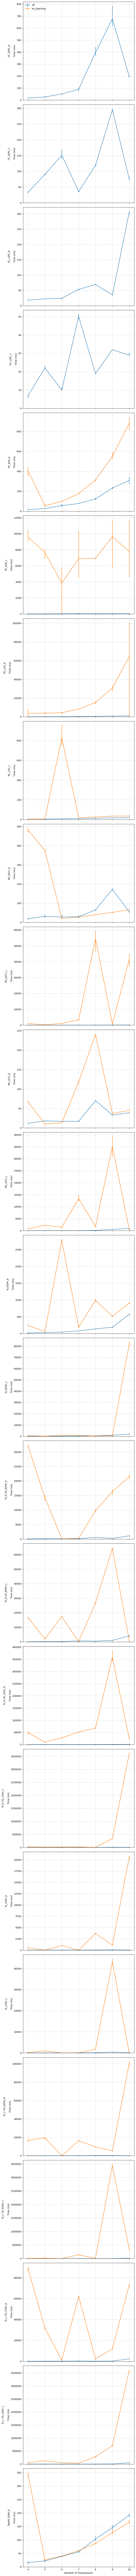

In [6]:
from plotting import plot

df = df[df['implementation'].isin(['all', 'no_learning'])]
df = df[df['expected'] == 'SAT']

plot(
    df,
    'solver',
    'problem',
    'implementation',
    styles=None,
    logScaling=False,
    plotHeight=6,
    plotWidth=8,
    display_level_fun=lambda x: x.__str__(),
    legend=True,
    y_unit="ms",
    sharey=True,
)

In [21]:
# Agregate results
# We merge together results for the same problem type
grouping_cols = [
    "problem_type",
    "implementation",
    "solver",
    "num_txn",
    "num_keys",
    "num_values",
    "num_sessions",
]

df = df[df['timeout'] == False]

df = (
    df.groupby(grouping_cols)
    .agg(
        avg_cand=("candidates", "mean"),
        min_cand=("candidates", "min"),
        max_cand=("candidates", "max"),
        avg_time_ms=("avg_time_ms", "mean"),
        min_time_ms=("min_time_ms", "min"),
        max_time_ms=("max_time_ms", "max"),
    )
    .reset_index()
)
df["avg_time_ms"] = df["avg_time_ms"].round().astype(int)
df

,problem_type,implementation,solver,num_txn,num_keys,num_values,num_sessions,avg_cand,min_cand,max_cand,avg_time_ms,min_time_ms,max_time_ms
0,"(SAT, 1)",all,glucose,4,5,5,3,2.636364,1,7,15,4,40
1,"(SAT, 1)",all,glucose,5,5,5,3,3.363636,1,9,26,5,64
2,"(SAT, 1)",all,glucose,6,5,5,3,2.818182,1,13,42,7,111
3,"(SAT, 1)",all,glucose,7,5,5,3,3.272727,1,10,63,9,131
4,"(SAT, 1)",all,glucose,8,5,5,3,5.181818,1,29,207,13,688
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,"(UNSAT, 2)",no_smart_search,glucose,6,5,5,3,746.875000,1,3297,93056,49,359232
120,"(UNSAT, 2)",no_smart_search,glucose,7,5,5,3,5.600000,1,11,3645,81,16783
121,"(UNSAT, 2)",no_smart_search,glucose,8,5,5,3,5.800000,1,9,8063,164,37064
122,"(UNSAT, 2)",no_smart_search,glucose,9,5,5,3,4.800000,1,9,20411,359,96781


434686


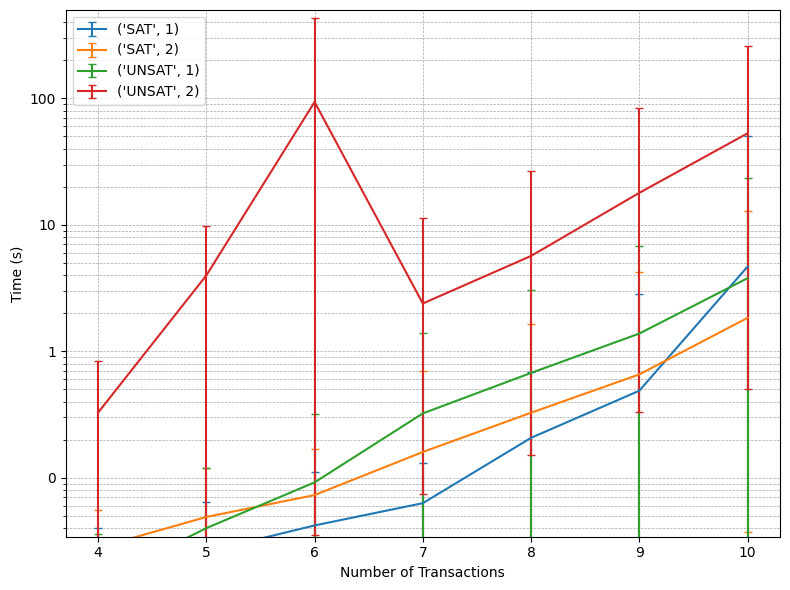

In [23]:
from plotting import plot

df = df[df['implementation'] == 'all']

plot(
    df,
    'implementation',
    'solver',
    'problem_type',
    styles=None,
    logScaling=True,
    plotHeight=6,
    plotWidth=8,
    paths=['./image.pdf'],
    base_dir=None,
    display_level_fun=None,
    legend=True,
    y_unit="auto",
    sharey=False,
)